In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
from datetime import datetime
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [98]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
df_berk = pd.read_csv(f"{homedir}/data/us/aggregate_berkeley.csv")

In [99]:
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))

In [100]:
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))

In [126]:
# Gets the number of deaths per day of a given county along with the time, counted in days
# since Jan 1st
def get_delta_deaths(fips, normalize=True):
    Y = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
    Y_county = Y.loc[Y['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date('2020-02-01')).days)
    X, y = (Y_county.time.values, Y_county.deaths.values)
    if not normalize:
        return X, y
    start_i = X[0]
    if start_i > 0:
        for i in range(start_i-1, -1, -1):
            X = np.insert(X, 0, i, axis=0)
            y = np.insert(y, 0, 0, axis=0)
    if start_i < 0:
        X = X[-start_i:]
        y = y[-start_i:]
    return X, y
def get_date(datestr):
    return datetime.strptime(datestr, '%Y-%m-%d')
# returns an X, y where y[i] is the number of deaths on day i divided by the running average
def get_delta_deaths_ratio(fips, avg_period=5, normalize=True):
    X_raw, y_raw = get_delta_deaths(fips, normalize)
    y = []
    running_sum = 0.0
    running_time = 0
    for i in X_raw:
        if y_raw[i] == 0:
            y.append(0)
        elif running_sum == 0:
            y.append(1) # if this is the first case we define the signal as 1
        else:
            avg = running_sum/running_time
            y.append(y_raw[i]/avg)
        if running_time == avg_period:
            running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
        else:
            running_sum = running_sum + y_raw[i]
            running_time = running_time + 1    
        if running_sum == 0:
            running_time = 1
    return (X_raw, np.array(y))

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


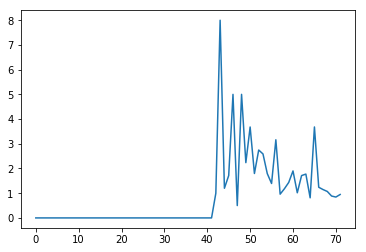

In [127]:
# some counties: King (53033), NYC (36061), Chicago (17031), LA (6037), Wayne, MI (26163)
X, y = get_delta_deaths_ratio(36061)
plt.plot(X, y)